## 1. Problem Definition
* This is a binary classification problem on either a customer is churn or not

* We will use several features to predict(classify) customers will churn or not

## 2. Data
**Data source:** [Kaggle](https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset)

There are 11 features and 1 target column.

## 3. Evaluation
What define success(Proof Of Concept): we decided to move forward the project if we meet 85% accuracy. However, as the experimentational characteristic of machine learning this evaluation metric can be changed along the way.

## 4. Features
The 11 independent columns are the following.
1. customer_id, unused variable.
2. credit_score, used as input.
3. country, used as input.
4. gender, used as input.
5. age, used as input.
6. tenure, used as input.
7. balance, used as input.
8. products_number, used as input.
9. credit_card, used as input.
10. active_member, used as input.
11. estimated_salary, used as input.

The target column is the following
- churn, used as the target. 1 if the client has left the bank during some period or 0 if he/she has not.

### Importing tools

In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

### Load Data

In [171]:
df = pd.read_csv("Bank Customer Churn Prediction.csv")
df.shape

(10000, 12)

In [172]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## EDA (Exploratory Data Analysis)

In [5]:
# let's see how many people are in each categories (1: churn, 0: not churn)
df.churn.value_counts()

0    7963
1    2037
Name: churn, dtype: int64

We can see that the target values are not balanced between the two.

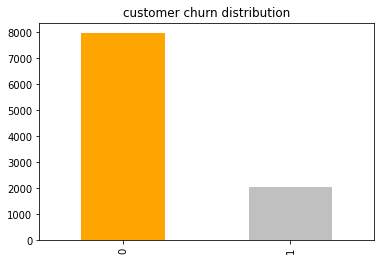

In [6]:
# plot the target 
df.churn.value_counts().plot.bar(color=["orange", "silver"])
plt.title("customer churn distribution");

In [9]:
# let's see if we have missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


There is no missing value in every columns.

In [11]:
# let's make a baseline assumption: if a customer is an active_member, they might not be churn
df.active_member.value_counts()

1    5151
0    4849
Name: active_member, dtype: int64

#### active member vs. churn
It seems that if a member is active, the churn rate will decrease. Let's see if that is relavant assumption.

In [12]:
pd.crosstab(df.churn, df.active_member)

active_member,0,1
churn,,
0,3547,4416
1,1302,735


From the table, we can assume that out of about 5000 active member, 700 of them became churn (14%), where as out of about 5000 inactive members, 1300 became churn (26%).

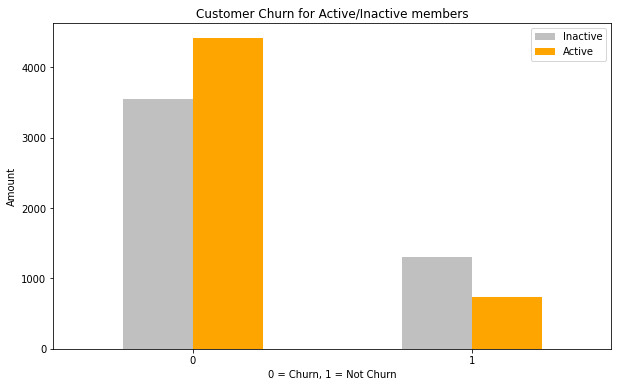

In [14]:
# let's make a bar plot
pd.crosstab(df.churn, df.active_member).plot.bar(figsize=(10,6), color=["silver", "orange"])

# Add some attributes to it
plt.title("Customer Churn for Active/Inactive members")
plt.xlabel("0 = Churn, 1 = Not Churn")
plt.ylabel("Amount")
plt.legend(["Inactive", "Active"])
plt.xticks(rotation=0); # keep the labels on the x-axis vertical

This plot shows that among churn customers, there are inactive members as twice as active members, showing the importance of keep customers to be active users in customer retention strategy.

#### product_number vs. estimated_salary
Let's see if there is a relation between balance and estimated_salary with regard to customer churn.

<function matplotlib.pyplot.switch_backend(newbackend)>

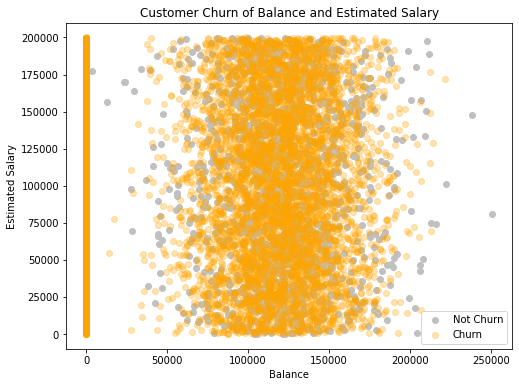

In [23]:
# Create another figure
plt.figure(figsize=(8,6))

# Start with positve examples
plt.scatter(df.balance[df.churn==1], 
            df.estimated_salary[df.churn==1], 
            c="silver") # define it as a scatter figure

# Now for negative examples, we want them on the same plot, so we call plt again
plt.scatter(df.balance[df.churn==0], 
            df.estimated_salary[df.churn==0], 
            c="orange", alpha=0.3) # axis always come as (x, y)

# Add some helpful info
plt.title("Customer Churn of Balance and Estimated Salary")
plt.xlabel("Balance")
plt.legend(["Not Churn", "Churn"])
plt.ylabel("Estimated Salary")
plt.switch_backend

This plot suggests that if a balance is 0, there is high possibility of being churn. Let's see if that is the case by looking into the data.

In [32]:
df[(df.balance==0)&(df.churn==1)].churn.sum()

500

When the balance is 0, 50% of customers whose balance is 0 will be churn. Thus, whether a balance is 0 or not will be crucial indicator in predicting customer churn.

#### product number vs. churn
Let's see if there are specific product categories indicating customer churn. Since product number if categorical variable, we will use barplot.

In [54]:
df.products_number.value_counts()

1    5084
2    4590
3     266
4      60
Name: products_number, dtype: int64

In [33]:
pd.crosstab(df.churn, df.products_number)

products_number,1,2,3,4
churn,,,,
0,3675,4242,46,0
1,1409,348,220,60


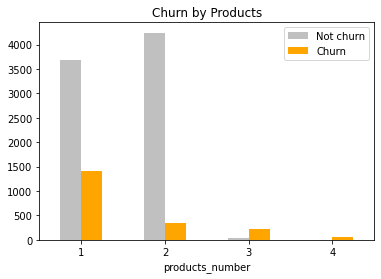

In [58]:
pd.crosstab(df.churn, df.products_number).T.plot.bar(color=['silver', 'orange'], 
                                                    title="Churn by Products")
plt.xticks(rotation=0)
plt.legend(["Not churn", "Churn"]);                                                

This plot indicates that product 3 and 4 need to be imporved in customer retention.

In [53]:
# Let's see percentage of each product category
pd.crosstab(df.churn, df.products_number).apply(lambda c:round(c/sum(c)*100,2), axis=0)

products_number,1,2,3,4
churn,,,,
0,72.29,92.42,17.29,0.0
1,27.71,7.58,82.71,100.0


product 2 is good at customer retention given that the users for that product is similar to those of product 1. We can look into why this is happening and the charateristic of product 2 to unilize in customer retention strategy in the future.
There are indeed problems in product 3 and 4 in customer retention.

### Correlation between independent variables

In [61]:
# Find the correlation between our independent variables
corr_matrix = df.corr()
corr_matrix 

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
customer_id,1.000000,0.005308,0.009497,-0.014883,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
credit_score,0.005308,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,0.009497,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,-0.014883,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
balance,-0.012419,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
products_number,0.016972,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
credit_card,-0.014025,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
active_member,0.001665,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimated_salary,0.015271,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
churn,-0.006248,-0.027094,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


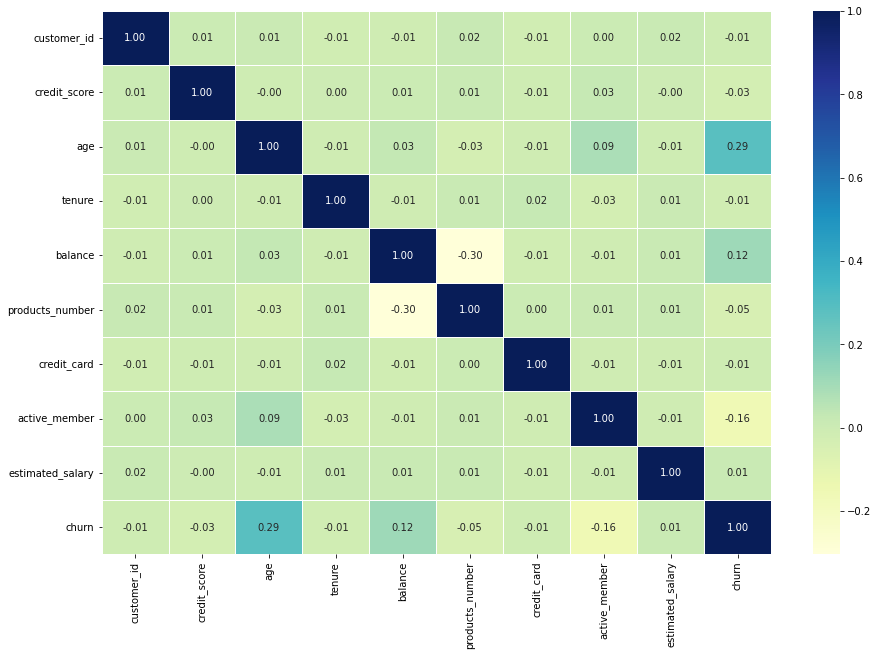

In [80]:
# Let's make it look a little more intuitively
corr_matrix = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu");

It seems that each pair of different numerical independent values has just small correlation. 

## 5. Modeling

After EDA, we will use meachine learning model to answer the question.

> The question: Can we predict whether a customer will be churn using 10 independent variables?

> What define success? We will continue this project when the accuracy exceeds 85% during Proof Of Concept.

In [86]:
# Let's look at the data again.
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   products_number   10000 non-null  int64  
 7   credit_card       10000 non-null  int64  
 8   active_member     10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  churn             10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


### Convert strings to categories
We have country, gender as string categorical variables. To fit a model, we will convert these two variables into numerical format.

In [173]:
df_tmp = df.copy()

In [174]:
pd.api.types.is_string_dtype(df_tmp["country"]), pd.api.types.is_string_dtype(df_tmp["gender"])

(True, True)

In [175]:
df_tmp.country.value_counts()

France     5014
Germany    2509
Spain      2477
Name: country, dtype: int64

In [176]:
df_tmp.gender.value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

In [177]:
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.codes

In [178]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  int8   
 3   gender            10000 non-null  int8   
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), int8(2)
memory usage: 800.9 KB


In [179]:
df_tmp.country.value_counts() #0: France, 1: Germany, 2: Spain

0    5014
1    2509
2    2477
Name: country, dtype: int64

In [180]:
df_tmp.gender.value_counts() #0: Female, 1: Male

1    5457
0    4543
Name: gender, dtype: int64

In [181]:
# Divide the dataset into X and y
df = df_tmp.drop("customer_id", axis=1) # Since the customer_id is unique value, we will drop this column in modeling.
X = df_tmp.drop("churn", axis=1)
y = df_tmp.churn

In [182]:
X.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
0,15634602,619,0,0,42,2,0.00,1,1,1,101348.88
1,15647311,608,2,0,41,1,83807.86,1,0,1,112542.58
2,15619304,502,0,0,42,8,159660.80,3,1,0,113931.57
3,15701354,699,0,0,39,1,0.00,2,0,0,93826.63
4,15737888,850,2,0,43,2,125510.82,1,1,1,79084.10


In [183]:
y.head()

0    1
1    0
2    1
3    0
4    0
Name: churn, dtype: int64

### Training and test split

In [184]:
# Random seed for reproducibility
np.random.seed(23)

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, # independent variables 
                                                    y, # dependent variable
                                                    test_size = 0.2) # percentage of data to use for test set

In [185]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8000, 11), (8000,), (2000, 11), (2000,))

For this problem, we will use 3 models and compare results.

    1. KNeiborsClassifier
    2. Logistic Regression
    3. Random Forest

In [186]:
# Put models in a dictionary
models = {"KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(), 
          "Random Forest": RandomForestClassifier()}

# Create function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(23)
    # Make a list to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [187]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

{'KNN': 0.753, 'Logistic Regression': 0.802, 'Random Forest': 0.857}

### Model Comparison
Since the Random Forest model showed 85.7% of accuracy. We satisfied the threshold of this PoC and devleop this model to be used in real business environment to predict customer churn.

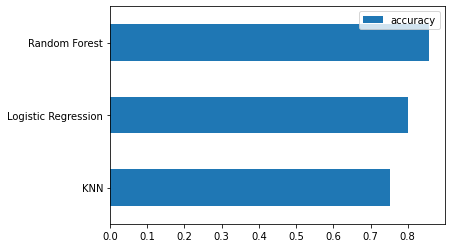

In [203]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.barh();

### Hyperparameter tuning and cross-validation

1. using `RandomizedSearchCV` to narrow down important hyperparameters
2. `GridSearchCV` to iterate exhausive combinaiton of hyperparameters

#### Tuning models with with RandomizedSearchCV

In [207]:
# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [208]:
# Setup random seed
np.random.seed(23)

# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           n_jobs=-1
                           verbose=True)

# Fit random hyperparameter search model
rs_rf.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [209]:
# Find the best parameters
rs_rf.best_params_

{'n_estimators': 460,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_depth': None}

In [210]:
# Evaluate the randomized search random forest model
rs_rf.score(X_test, y_test)

0.86

#### Tuning a model with GridSearchCV

In [212]:
# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(300, 600, 50),
           "max_depth": [None],
           "min_samples_split": np.arange(2, 10, 2),
           "min_samples_leaf": np.arange(1, 10, 2)}

# Setup grid hyperparameter search for RandomForestClassifier
gs_rf_clf = GridSearchCV(RandomForestClassifier(),
                         param_grid=rf_grid,
                         cv=5,
                         n_jobs=-1,
                         verbose=True)

# Fit grid hyperparameter search model
gs_rf_clf.fit(X_train, y_train);

Fitting 5 folds for each of 120 candidates, totalling 600 fits


In [214]:
# Check the best parameters
gs_rf_clf.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 300}

In [215]:
# Evaluate the model
gs_rf_clf.score(X_test, y_test)

0.868

After doing hyperparameter tuning, we increased the accuracy score by 1%.

### Evaluating a classification model, beyond accuracy 

In [216]:
# Make preidctions on test data
y_preds = gs_rf_clf.predict(X_test)

In [217]:
y_preds

array([0, 1, 1, ..., 0, 1, 0])

In [220]:
np.array(y_test)

array([0, 1, 1, ..., 0, 1, 0])

#### ROC Curve and AUC Scores

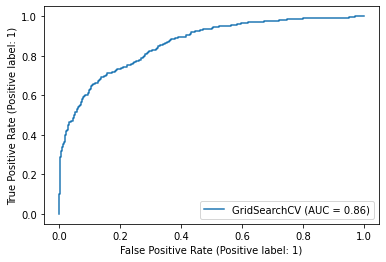

In [237]:
RocCurveDisplay.from_estimator(gs_rf_clf, X_test, y_test)

AUC scores is 0.86. The threshold of determining a record to be positive becomes lower(liberal classifier) moving to the upper right corner, and it becomes higer (strict classifier) moving to the lower left corner. 

#### Confusion matrix

In [239]:
# Display confusion matrix
print(confusion_matrix(y_test, y_preds))

[[1557   47]
 [ 217  179]]


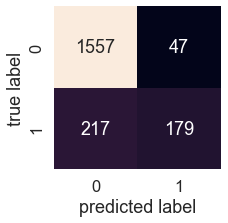

In [260]:
sns.set(font_scale=1.5) # Increase font size

def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True, # Annotate the boxes
                     fmt='d', 
                     cbar=False)
    plt.xlabel("predicted label")
    plt.ylabel("true label")
plot_conf_mat(y_test, y_preds)

#### Classification report

In [254]:
# Show classification report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1604
           1       0.79      0.45      0.58       396

    accuracy                           0.87      2000
   macro avg       0.83      0.71      0.75      2000
weighted avg       0.86      0.87      0.85      2000



We have class imbalance: about 4 times more 0-class values than 1-class values. Therefore, focus on macro avg, which is a metric taking into acount class imbalance.

In [261]:
precision = 179 / (47+179) # TP / FP+TP (Positive by prediction)
precision

0.7920353982300885

In [263]:
recall = 179 / (217+179) # TP / FN + TP (Positive as the ground truth)
recall

0.45202020202020204

#### Best hyperparameters

In [264]:
# Check best hyperparameters
gs_rf_clf.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 300}